In [ ]:
# pip install umap-learn --quiet

In [ ]:
# pip install umap-learn[plot] --quiet

In [1]:
!git clone https://github.com/WillKoehrsen/feature-selector.git

Cloning into 'feature-selector'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 122 (delta 28), reused 24 (delta 24), pack-reused 88
Receiving objects: 100% (122/122), 5.06 MiB | 8.57 MiB/s, done.
Resolving deltas: 100% (45/45), done.


 # Импорт библиотек

In [3]:
import numpy as np
import pandas as pd

from feature_selector import FeatureSelector

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Объявление функций

In [2]:
def roc_auc_score_multiclass(actual_class, pred_class, average="weighted"):
  unique_class = set(actual_class)
  roc_auc_dict = {}

  for per_class in unique_class:
    other_class = [x for x in unique_class if x != per_class]

    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict


def print_dict(d, indent=0):
  for key, value in d.items():
    print(str(key) + '\t' + str(value))

# Основной код

### 1. Найти данные для классификации.
Данные в группе повторяться не должны! Предобработать данные, если это необходимо.

In [4]:
df = pd.read_csv('archive (2).zip')
df.drop('index', axis=1, inplace=True)
print(df.shape)
df.head(4)

(1586614, 13)


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969


**Описание датасета**

**brewery_name** - Название пивоварни, которая произвела пиво. (String)

**review_time** - Дата и время написания отзыва. (String)

**review_overall** - Общая оценка пива рецензентом по шкале от 1 до 5. (Float)

**review_aroma** - Оценка аромата пива рецензентом по шкале от 1 до 5. (Float)

**review_appearance** - Оценка рецензентом внешнего вида пива по шкале от 1 до 5. (Float)

**review_profilename** - Имя рецензента. (String)

**beer_style** - Вид пива. (String)

**review_palate** - Оценка вкуса пива рецензентом по шкале от 1 до 5. (Float)

**review_taste** - Оценка послевкусия пива рецензентом по шкале от 1 до 5. (Float)

**beer_name** - Название пива.(String)

**beer_abv** - Градус пива. (Float)

In [6]:
df.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

In [7]:
df.beer_abv.value_counts()

5.00     109144
8.00      67744
6.00      65383
7.00      59460
9.00      59183
          ...  
7.17          1
7.74          1
17.35         1
3.53          1
0.08          1
Name: beer_abv, Length: 530, dtype: int64

In [8]:
df.beer_abv.median()

6.5

In [5]:
df = df.fillna({'beer_abv': int(df.beer_abv.mode()),
                'brewery_name': df.brewery_name.mode()[0]})
df = df.dropna(subset=['review_profilename'])
df.isna().sum()

brewery_id            0
brewery_name          0
review_time           0
review_overall        0
review_aroma          0
review_appearance     0
review_profilename    0
beer_style            0
review_palate         0
review_taste          0
beer_name             0
beer_abv              0
beer_beerid           0
dtype: int64

In [6]:
df.review_profilename = df.review_profilename.astype('category').cat.codes
df.brewery_name = df.brewery_name.astype('category').cat.codes
df.beer_style = df.beer_style.astype('category').cat.codes
df.dtypes

brewery_id              int64
brewery_name            int16
review_time             int64
review_overall        float64
review_aroma          float64
review_appearance     float64
review_profilename      int32
beer_style               int8
review_palate         float64
review_taste          float64
beer_name              object
beer_abv              float64
beer_beerid             int64
dtype: object

In [10]:
fs = FeatureSelector(data=df.loc[:, df.columns != 'review_overall'],
                     labels=df['review_overall'])

In [11]:
fs.identify_collinear(correlation_threshold=0.5)

3 features with a correlation magnitude greater than 0.50.



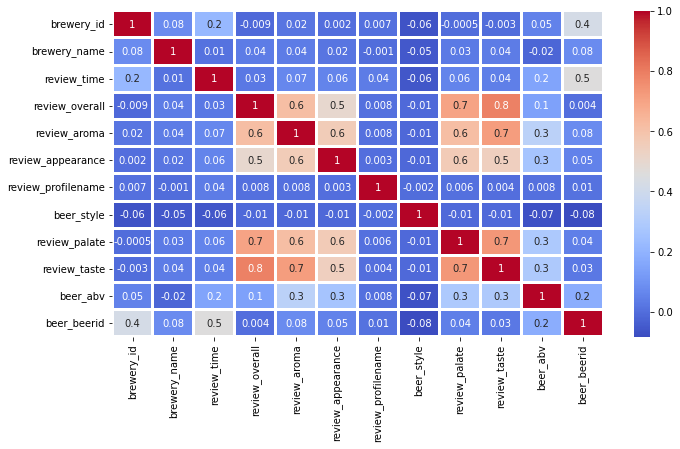

In [12]:
plt.figure(figsize=(11,6))
sns.heatmap(df.corr(), annot=True, fmt='.1g',
            linewidths=2, cmap='coolwarm');

In [13]:
correlated_features = fs.ops['collinear']
correlated_features

['review_appearance', 'review_palate', 'review_taste']

In [14]:
fs.record_collinear

,drop_feature,corr_feature,corr_value
0,review_appearance,review_aroma,0.561008
1,review_palate,review_aroma,0.616937
2,review_palate,review_appearance,0.566647
3,review_taste,review_aroma,0.716769
4,review_taste,review_appearance,0.546980
5,review_taste,review_palate,0.734122


In [15]:
df[['review_appearance', 'review_palate', 'review_taste']].nunique()

review_appearance    10
review_palate         9
review_taste          9
dtype: int64

In [7]:
df.drop(['review_palate', 'beer_beerid', 'brewery_id', 'beer_name', 'review_profilename'], axis=1, inplace=True)

In [12]:
df.duplicated().any()

True

In [8]:
df.drop_duplicates(inplace=True)
df.shape

(1586251, 8)

In [19]:
df.columns

Index(['brewery_name', 'review_time', 'review_overall', 'review_aroma',
       'review_appearance', 'beer_style', 'review_taste', 'beer_abv'],
      dtype='object')

In [19]:
df.describe()

,brewery_name,review_time,review_overall,review_aroma,review_appearance,beer_style,review_taste,beer_abv
count,1.586251e+06,1.586251e+06,1.586251e+06,1.586251e+06,1.586251e+06,1.586251e+06,1.586251e+06,1.586251e+06
mean,2.905199e+03,1.224100e+09,3.815628e+00,3.735683e+00,3.841671e+00,4.214235e+01,3.792921e+00,6.955215e+00
std,1.729732e+03,7.654420e+07,7.205944e-01,6.975680e-01,6.160662e-01,3.302103e+01,7.319107e-01,2.309645e+00
min,0.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-02
25%,1.325000e+03,1.173236e+09,3.500000e+00,3.500000e+00,3.500000e+00,1.200000e+01,3.500000e+00,5.100000e+00
50%,2.880000e+03,1.239222e+09,4.000000e+00,4.000000e+00,4.000000e+00,3.100000e+01,4.000000e+00,6.300000e+00
75%,4.581000e+03,1.288572e+09,4.500000e+00,4.000000e+00,4.000000e+00,7.400000e+01,4.500000e+00,8.400000e+00
max,5.741000e+03,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,1.030000e+02,5.000000e+00,5.770000e+01


### 2. Изобразить гистограмму, которая показывает баланс классов.
Сделать выводы.

In [20]:
df.nunique()

brewery_name            5742
review_time          1577615
review_overall            10
review_aroma               9
review_appearance         10
beer_style               104
review_taste               9
beer_abv                 530
dtype: int64

Необходимо отобразить распределение оценок рецензий.

Text(0, 0.5, 'Частота')

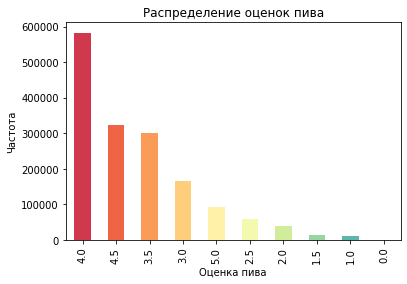

In [21]:
pd.value_counts(df.review_overall).plot.bar(color=sns.color_palette("Spectral", 10))
plt.title('Распределение оценок пива')
plt.xlabel('Оценка пива')
plt.ylabel('Частота')

In [22]:
np.unique(df[["review_overall"]].values.flatten())

array([0. , 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

Как видно, классы оценок сильно не сбалансированны. Попробуем это выправить c учетом того, что нам предпочтительнее хорошо определять оценки до 3.0.

In [9]:
df_major = df.loc[df.review_overall == 4]
df_medium = df.loc[df.review_overall.isin([4.5, 3.5, 3.0])]
df_minor = df.loc[df.review_overall.isin([4, 4.5, 3.5, 3.0]) == False]


df_major_sample = resample(df_major,
               replace=True,
               n_samples=35000,
               random_state=7)

df_medium_sample = resample(df_medium,
               replace=True,
               n_samples=85000,
               random_state=2)

df_minor_sample = resample(df_minor,
               replace=True,
               n_samples=75000,
               random_state=47)
  
df_sample = pd.concat([df_major_sample, df_medium_sample, df_minor_sample])
df_sample.head(3)

,brewery_name,review_time,review_overall,review_aroma,review_appearance,beer_style,review_taste,beer_abv
510323,396,1300578875,4.0,4.5,4.0,57,4.0,11.0
1562403,2440,1289447220,4.0,4.0,4.0,94,4.5,7.5
1458304,3996,1294123330,4.0,3.5,4.0,89,4.5,10.5


Text(0, 0.5, 'Частота')

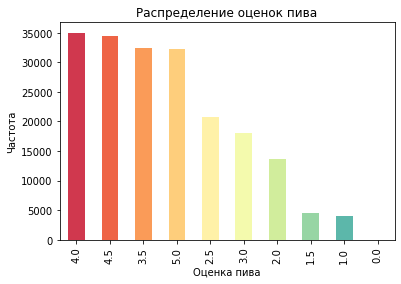

In [10]:
pd.value_counts(df_sample.review_overall).plot.bar(color=sns.color_palette("Spectral", 10))
plt.title('Распределение оценок пива')
plt.xlabel('Оценка пива')
plt.ylabel('Частота')

Удалось добиться заметного уменьшения данных. Однако к df_sample мы вернемся позже.

In [ ]:
# X, y = df.drop("review_overall", axis=1), df[["review_overall"]].values.flatten()
# X.head()

In [ ]:
# X = MinMaxScaler().fit_transform(X)
# y = LabelEncoder().fit_transform(y)

In [ ]:
# X.mean(axis=0)

In [ ]:
# X.std(axis=0)

In [ ]:
# plt.figure(figsize=(10, 8))
# sns.violinplot(data=[X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7]], palette='rainbow');

Для df_sample:

In [11]:
X_s, y_s = df_sample.drop("review_overall", axis=1), df_sample[["review_overall"]].values.flatten()
# X_s.head().sample(9, axis=1)

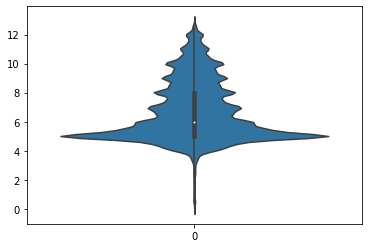

In [25]:
sns.violinplot(data=X_s.loc[X_s['beer_abv'] < 13]['beer_abv']);

In [27]:
X_s.iloc[:, 6].value_counts()

5.00     23317
8.00      8248
6.00      7624
5.50      7284
7.00      7049
         ...  
9.23         1
4.41         1
17.20        1
19.37        1
29.00        1
Name: beer_abv, Length: 419, dtype: int64

In [28]:
y_s

array([4. , 4. , 4. , ..., 2. , 5. , 2.5])

In [12]:
# quantile_transformer = QuantileTransformer(output_distribution='normal', random_state= 0)
# X_s = quantile_transformer.fit_transform(X_s)
X_s = MinMaxScaler().fit_transform(X_s)
y_s = LabelEncoder().fit_transform(y_s)

In [ ]:
# labelEncoder.classes_

In [30]:
X_s.mean(axis=0)

array([0.50040336, 0.75888557, 0.65502115, 0.75277538, 0.40904884,
       0.65694038, 0.16755274])

In [31]:
X_s.std(axis=0)

array([0.30238336, 0.17775387, 0.21467984, 0.14775132, 0.3193796 ,
       0.23964668, 0.05859745])

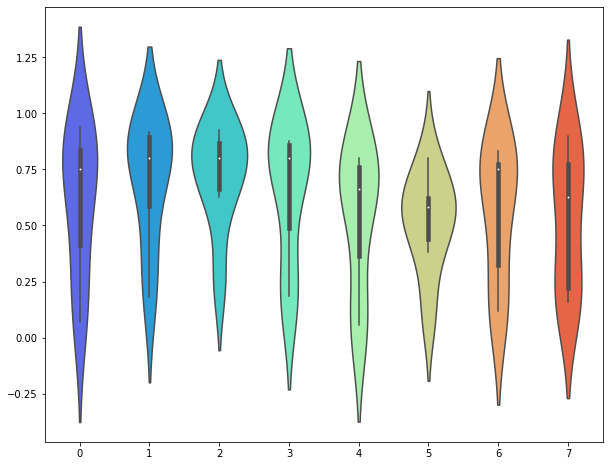

In [27]:
plt.figure(figsize=(10, 8))
sns.violinplot(data=[X_s[0], X_s[1], X_s[2], X_s[3], X_s[4], X_s[5], X_s[6], X_s[7]], palette='rainbow');

### 3. Разбить выборку на тренировочную и тестовую.
Тренировочная для обучения модели, тестовая для проверки ее качества.

In [33]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=29)

# print('Размер для признаков обучающей выборки', x_train.shape)
# print('Размер для целевого показателя обучающей выборки', y_train.shape)
# print('Размер для признаков тестовой выборки', x_test.shape)
# print('Размер для целевого показателя выборки', y_test.shape)

Для df_sample:

In [14]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, train_size=0.8, shuffle=True, random_state=29)

print('Размер для признаков обучающей выборки', x_train_s.shape)
print('Размер для целевого показателя обучающей выборки', y_train_s.shape)
print('Размер для признаков тестовой выборки', x_test_s.shape)
print('Размер для целевого показателя выборки', y_test_s.shape)

Размер для признаков обучающей выборки (156000, 7)
Размер для целевого показателя обучающей выборки (156000,)
Размер для признаков тестовой выборки (39000, 7)
Размер для целевого показателя выборки (39000,)


### 4. Применить алгоритмы классификации.
Логистическая регрессия, SVM, 
KNN. Построить матрицу ошибок по результатам работы моделей 
(использовать confusion_matrix из sklearn.metrics).
accuracy, precision, 
recall и f1-меру (можно использовать classification_report из 
sklearn.metrics). Также сравнить время работы алгоритмов. Сделать 
выводы.

### **Логистическая регрессия**

In [ ]:
model = LogisticRegression(random_state=1, C=0.09, class_weight="balanced")

In [ ]:
# model.fit(x_train, y_train)
# y_predict = model.predict(x_test)
# y_proba = model.predict_proba(x_test)
# print('Предсказанные:', y_predict)
# print('Исходные:', np.array(y_test))

In [ ]:
# print(classification_report(y_test, y_predict))

In [ ]:
# print("\nROC-AUC score:")
# lr_roc_auc_multiclass = roc_auc_score_multiclass(y_test, y_proba[:, 1])
# print_dict(lr_roc_auc_multiclass)

In [ ]:
# print(f'Accuracy Score: {accuracy_score(y_test, y_predict)}')
# print(f'Recall score: {recall_score(y_test, y_predict, average= "weighted")}')

---

In [ ]:
model.fit(x_train_s, y_train_s)
y_predict_s = model.predict(x_test_s)
y_proba_s = model.predict_proba(x_test_s)
print('Предсказанные:', y_predict_s)
print('Исходные:', np.array(y_test_s))

Предсказанные: [2 8 7 ... 7 1 7]
Исходные: [3 7 6 ... 6 3 6]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print(classification_report(y_test_s, y_predict_s))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.44      0.75      0.56       794
           2       0.19      0.33      0.24       915
           3       0.39      0.34      0.36      2742
           4       0.53      0.34      0.42      4160
           5       0.35      0.47      0.40      3610
           6       0.51      0.45      0.48      6556
           7       0.42      0.44      0.43      7019
           8       0.40      0.25      0.30      6823
           9       0.53      0.73      0.61      6381

    accuracy                           0.44     39000
   macro avg       0.38      0.41      0.38     39000
weighted avg       0.45      0.44      0.43     39000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("\nROC-AUC score:")
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_test_s, y_proba_s[:, 1])
print_dict(lr_roc_auc_multiclass)


ROC-AUC score:
1	0.5
2	0.5
3	0.5
4	0.5
5	0.5
6	0.5
7	0.5
8	0.5
9	0.5


---

In [ ]:
crange = np.arange(0.0, 3.0, 0.5)
param_grid_lr = {
    'C': crange,
    'max_iter': [150, 200],                      
    'solver': ['lbfgs', 'liblinear', 'saga'],   
    'class_weight': ['balanced'],
    'penalty': ['l2']                                    
}

In [ ]:
logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=1234),
                             param_grid=param_grid_lr, verbose=1, cv=4, n_jobs=-1)

logModel_grid.fit(x_train_s, y_train_s)
print(logModel_grid.best_estimator_)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1541, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 1198, in _fit_liblinear
    sample_weight,
  File "sklearn/svm/_liblinear.pyx", line 52, in sklearn.svm._libl

LogisticRegression(C=2.0, class_weight='balanced', max_iter=200,
                   random_state=1234)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print(logModel_grid.best_estimator_)

LogisticRegression(C=2.0, class_weight='balanced', max_iter=200,
                   random_state=1234)


In [ ]:
model_2 = LogisticRegression(C=2.0, class_weight='balanced', max_iter=200, random_state=1234)

model_2.fit(x_train_s, y_train_s)
y_predict_s = model_2.predict(x_test_s)
y_proba_s = model_2.predict_proba(x_test_s)
print('Предсказанные:', y_predict_s)
print('Исходные:', np.array(y_test_s))

Предсказанные: [2 8 7 ... 7 2 7]
Исходные: [3 7 6 ... 6 3 6]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print(classification_report(y_test_s, y_predict_s))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      0.71      0.59       794
           2       0.25      0.39      0.31       915
           3       0.43      0.41      0.42      2742
           4       0.51      0.40      0.44      4160
           5       0.35      0.43      0.39      3610
           6       0.49      0.46      0.48      6556
           7       0.42      0.46      0.44      7019
           8       0.41      0.25      0.31      6823
           9       0.55      0.70      0.61      6381

    accuracy                           0.45     39000
   macro avg       0.39      0.42      0.40     39000
weighted avg       0.45      0.45      0.45     39000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


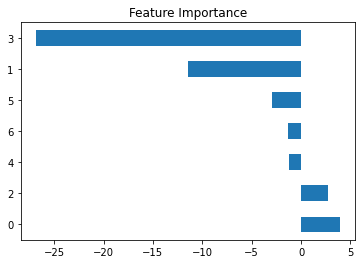

In [ ]:
importance = model_2.coef_[0]
feat_importances = pd.Series(importance)
feat_importances.nlargest(20).plot(kind='barh', title = 'Feature Importance')

In [ ]:
df.columns.tolist()[:2] + df.columns.tolist()[3:]

['brewery_name',
 'review_time',
 'review_aroma',
 'review_appearance',
 'beer_style',
 'review_taste',
 'beer_abv']

Наиболее важные признаки: 'review_time', 'review_appearance', 'brewery_name'

In [ ]:
fig = px.imshow(confusion_matrix(y_test_s, y_predict_s), text_auto=True)
fig.update_layout(xaxis_title='Target', yaxis_title='Prediction')

Для df_sample:

In [ ]:
print(classification_report(y_test_s, y_predict_s))

              precision    recall  f1-score   support

           0       0.13      1.00      0.23         3
           1       0.49      0.72      0.58      2153
           2       0.24      0.38      0.30      2616
           3       0.39      0.39      0.39      7691
           4       0.41      0.41      0.41     11688
           5       0.39      0.44      0.42     16777
           6       0.49      0.46      0.47     30754
           7       0.50      0.43      0.46     39996
           8       0.45      0.36      0.40     32545
           9       0.46      0.69      0.55     18178

    accuracy                           0.45    162401
   macro avg       0.40      0.53      0.42    162401
weighted avg       0.45      0.45      0.45    162401



In [104]:
fig = px.imshow(confusion_matrix(y_test_s, y_predict_s), text_auto=True)
fig.update_layout(xaxis_title='Target', yaxis_title='Prediction')

### **SVM**

In [15]:
param_kernel = ('linear', 'rbf')
parameters = {'kernel': param_kernel, 'class_weight': ['balanced']}
modelSVC = SVC()
grid_search_svm = GridSearchCV(estimator=modelSVC,
                               param_grid=parameters, cv=4)
grid_search_svm.fit(x_train_s, y_train_s)

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'class_weight': ['balanced'],
                         'kernel': ('linear', 'rbf')})

In [16]:
best_modelSVC = grid_search_svm.best_estimator_
print(best_modelSVC.kernel)
print(best_modelSVC)

rbf
SVC(class_weight='balanced')


In [17]:
svm_preds = best_modelSVC.predict(x_test_s)
print(classification_report(svm_preds, y_test_s))

              precision    recall  f1-score   support

           1       0.58      0.64      0.61       719
           2       0.47      0.35      0.40      1236
           3       0.46      0.50      0.48      2537
           4       0.44      0.55      0.49      3306
           5       0.44      0.36      0.40      4402
           6       0.48      0.50      0.49      6346
           7       0.52      0.40      0.45      9200
           8       0.42      0.44      0.43      6447
           9       0.52      0.69      0.59      4807

    accuracy                           0.48     39000
   macro avg       0.48      0.49      0.48     39000
weighted avg       0.48      0.48      0.47     39000



In [21]:
fig1 = px.imshow(confusion_matrix(y_test_s, svm_preds))
fig1.update_layout(xaxis_title ='Target', yaxis_title='Prediction')

### **KNN**

In [18]:
number_of_neighbors = np.arange(3, 10, 25)
modelKNN = KNeighborsClassifier()
param = {'n_neighbors':number_of_neighbors}
grid_search_knn = GridSearchCV(estimator=modelKNN, param_grid=param, cv=4)

In [19]:
grid_search_knn.fit(x_train_s, y_train_s)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([3])})

In [20]:
grid_search_knn.best_score_

0.3999423076923077

In [21]:
grid_search_knn.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [22]:
knn_predict = grid_search_knn.predict(x_test_s)
print(classification_report(knn_predict, y_test_s))

              precision    recall  f1-score   support

           1       0.62      0.49      0.55      1009
           2       0.33      0.29      0.31      1055
           3       0.47      0.39      0.43      3304
           4       0.49      0.41      0.45      4928
           5       0.29      0.27      0.27      3885
           6       0.41      0.38      0.40      7147
           7       0.34      0.36      0.35      6522
           8       0.34      0.42      0.38      5426
           9       0.54      0.60      0.57      5724

    accuracy                           0.41     39000
   macro avg       0.43      0.40      0.41     39000
weighted avg       0.41      0.41      0.41     39000



In [23]:
fig2 = px.imshow(confusion_matrix(y_test_s, knn_predict), text_auto=True)
fig2.update_layout(xaxis_title='Target', yaxis_title='Prediction')

### Вывод
Лучше всего справился SVM, но его запуск на сетке с двумя ядрами занял более 2,5 часов в отличие от двух других алгоритмов. Сравнивать метрики взвешенного avg